In [127]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
import fancyimpute 
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

# Machine Learning Modeling and Cross-Validation/Accuracy 
import sklearn

random_state = 1

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

## Train/Test/Validate Split

Like we did in the last section, we will split our data into a Training set, a Test set, and a Validation Set. We do this so that during our model fitting process, we do no overfit to the training set, which would cause our model to become less accurate when generalizing to new data. 

To avoid data leakage, we will make sure to split our data into our training set and test set *first*, then we will scale everything base on our **training set only**.

In [128]:
proc_df = pd.read_pickle("../data/processed.pkl")

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into 70% Training, 20% Test data, 10% Validation data
# We won't touch the Test data until after we have chosen our features and modeled/fit our training set with our validation set

X = proc_df.copy().drop('Separation', axis=1)
y = proc_df.copy()['Separation']

#log transform skewed numeric floating point (continuous) features:
float_cols = X.select_dtypes(include=['float64'])
float_cols = float_cols.columns

#Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state) 

# Scale Continuous independent variables (input features)
Scaler = StandardScaler()

#Fit scaler to Training Set
Fit = Scaler.fit(X_train[float_cols])

#Scale the continuous features for all the data, Full set, Training set, and Test set
X_train[float_cols] = Fit.transform(X_train[float_cols])
X_test[float_cols] = Fit.transform(X_test[float_cols])
X[float_cols] = Fit.transform(X[float_cols])

#Split Train Data into Train_2 and Validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state = random_state)

#How big are the data sets?
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_2.shape, X_val.shape, y_train_2.shape, y_val.shape

((34847, 46),
 (8712, 46),
 (34847,),
 (8712,),
 (30491, 46),
 (4356, 46),
 (30491,),
 (4356,))

<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' alt="Drawing" style="width: 450px;"/>

## Model Evaluation Prodecedure

The evaluation process for seeing how accurate my predictions are will be based on **MEAN ABSOLUTE ERROR**:

The reason that I am choosing Mean Absolute Error over more well-used errors like Root Mean Sqaured Error is because we do NOT want to penalize the model when predictions are way off. For example, if the model predicts 4 yards of separation, but there ends up being 15 yards of separation (blown coverage), I don't want the model to overreact and try to fit to that point, I'd rather create a more conservative model.

In [130]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# The error metric: Mean Absolute Error
def CV_MAE(model, X, y):
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=10)
    return (mae)

# Model Selection

Since the output of this model will be presented to Fans/General Mangers/Scouts alike, I think it very important that the model I design to be as simple, and as easy to understand as possible. To this end, I will test a few different linear regressors out, as well as some other ensemble ML models (XGBoost, LGBM, GBR) and see if there is a large discrepancy in model performance. Usually, the more complex, black box ensemble models will perform better, but if the difference isn't too large, I will prefer to use a simpler linear model instead to improve acceptance and comprehensability. 

In [131]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet, HuberRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#Linear Models
LR = LinearRegression()

#Ridge Regression
Ridge = RidgeCV()

#Lasso Regression
Lasso = LassoCV()

#Regression with Huber Loss
Huber = HuberRegressor()

#Ensemble Models - Tree-Based
rf = RandomForestRegressor(random_state=random_state)

#eXtreme Gradient Boosting Regressor 
xgb = XGBRegressor(eval_metric='mae', random_state=random_state)

# Light Gradient Boosting Regressor
LGBM = LGBMRegressor(metric = 'mae',random_state=random_state)

## Create Pipeline for scoring/transforming

In [132]:
%%time
#Linear Regression
LR_scores = CV_MAE(LR, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LR_scores.mean()))

Mean Absolute Error -1.466626
CPU times: user 1.09 s, sys: 101 ms, total: 1.19 s
Wall time: 476 ms


In [133]:
%%time
#Huber Loss Regression
Huber_scores = CV_MAE(Huber, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Huber_scores.mean()))

Mean Absolute Error -1.444373
CPU times: user 21.6 s, sys: 1.96 s, total: 23.5 s
Wall time: 12.3 s


In [90]:
%%time
#CrossValidated Ridge Regression
Ridge_scores = CV_MAE(Ridge, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Ridge_scores.mean()))

Mean Absolute Error -1.454043
CPU times: user 3.03 s, sys: 454 ms, total: 3.48 s
Wall time: 1.31 s


In [91]:
%%time
#Cross-Validated Lasso Regression
Lasso_scores = CV_MAE(Lasso, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Lasso_scores.mean()))

Mean Absolute Error -1.460598
CPU times: user 9.64 s, sys: 1.05 s, total: 10.7 s
Wall time: 4.41 s


In [92]:
%%time
#Random Forest Regression
RandomForest_scores = CV_MAE(rf, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * RandomForest_scores.mean()))

Mean Absolute Error -1.394619
CPU times: user 5min 57s, sys: 4.64 s, total: 6min 2s
Wall time: 6min 16s


In [93]:
%%time
#eXtreme Gradient Boosted Regression
xgb_scores = CV_MAE(xgb, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * xgb_scores.mean()))

Mean Absolute Error -1.392552
CPU times: user 2min 33s, sys: 2.05 s, total: 2min 35s
Wall time: 49.7 s


In [134]:
%%time
#Light Gradient Boosted Model
LGBM_scores = CV_MAE(LGBM, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LGBM_scores.mean()))

Mean Absolute Error -1.364706
CPU times: user 16.3 s, sys: 797 ms, total: 17.1 s
Wall time: 4.87 s


In [95]:
MAE_error=[LR_scores.mean(),Huber_scores.mean(), Lasso_scores.mean(), RandomForest_scores.mean(),xgb_scores.mean(),LGBM_scores.mean()]

col={'Avg MAE':MAE_error}
models=['Linear Regression','Huber Loss Regression', 'Lasso Regression','Random Forest','XGBoost','Light GBM']
Scoring_df=pd.DataFrame(data=col,index=models)

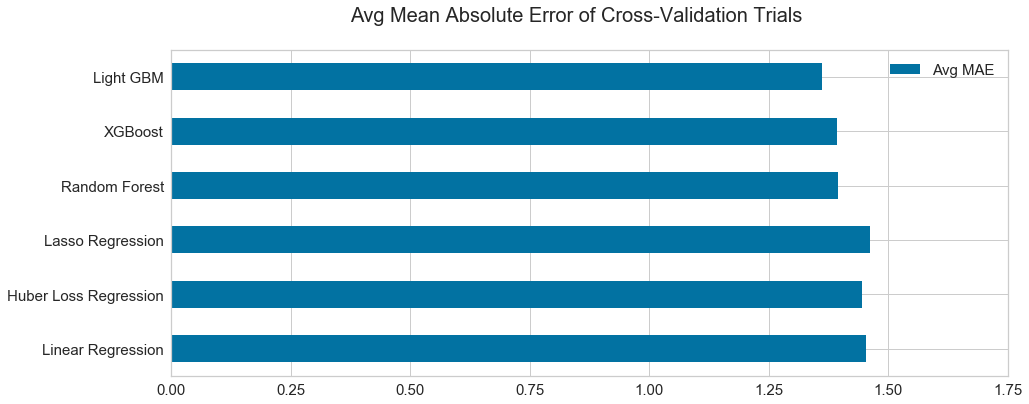

In [96]:
fig, ax = plt.subplots(figsize=(15, 6))
Scoring_df.plot(kind='barh', ax = ax)
ax.tick_params(labelsize=15)
plt.xticks(np.arange(0, 2, step=0.25))
ax.legend( prop={'size': 15})
A = fig.suptitle('Avg Mean Absolute Error of Cross-Validation Trials', fontsize=20)

The **Light Gradient Boosted Model** creates the lowest Mean Absolute Error, so I will choose this as my baseline model moving forward [(reference)](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

# Residuals and Results

In [135]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import ValidationCurve

As we can see below, since the distribution of output variable (Separation) is so right skewed it is causing the distribution of our residuals to be skewed as well. In Linear Regression, one of the assumptions we make for our model to be valid is that the residuals are normally distributed. In this case, since the Mean Absolute Error for the Light Gradient Boosted model was the lowest (best), we do not need these assumptions to hold, as this is no longer linear regression.

For reference, LGBM is a fast, high-performance gradient boosting framework based on decision tree algorithms.[(more info)](https://lightgbm.readthedocs.io/en/latest/)

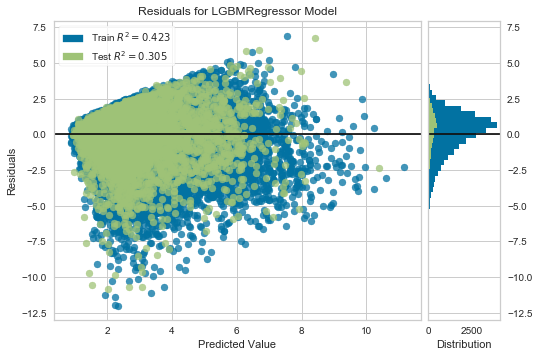

In [136]:
LGBM_fit = LGBM.fit(X_train_2, y_train_2)

visualizer = ResidualsPlot(LGBM_fit)
visualizer.fit(X_train_2, y_train_2)
visualizer.score(X_val, (y_val))
A = visualizer.show()

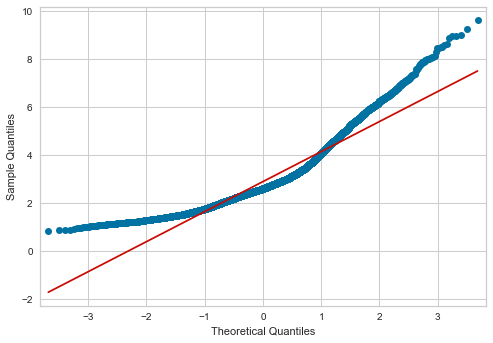

In [137]:
#QQ plot to show distribution of residuals
import statsmodels.api as sm

LGBM_fit.fit(X_train_2, y_train_2)
y_hat = LGBM_fit.predict(X_test)

# Create QQ plot
sm.qqplot(y_hat, line='s')
plt.show()


## Hyperparameter Tuning the Light Gradient Boosted Model

Below I use a library called [optuna](https://github.com/optuna/optuna) that helps with automatically hyperparameter tuning various ML models. As per suggestion on the documentation, it appears as though the 'num_leaves','min_data_in_leaf', and 'max_depth' are the most importand variables to tune, so I started here. With more time and resources, I would use more variants of other paramters to help with tuning. 

   1. **num_leaves:** describes the number of splits in the decision tree, higher is more accurate, but tends to lead to over fitting
   2. **min_data_in_leaf:** helps prevent overfitting, setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
   3. **max_depth:** is an explicit way to limit the tree depth

In [ ]:
import optuna
import optuna.integration.lightgbm as lgb

    
def objective(trial):
    
    
    dtrain = lgb.Dataset(X_train_2, label=y_train_2)
    dval = lgb.Dataset(X_val, label=y_val)
 
    params = {
    'objective': 'regression',
    'metric': 'l1',
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0), #regularization parameter #1
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0), # regularization parameter #1
    'num_leaves': trial.suggest_int('num_leaves', 2, 256), 
    'min_data_in_leaf': trial.suggest_loguniform('min_data_in_leaf', 100, 1e5),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(
    params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=100,
)
    preds = gbm.predict(X_val)
    val_MAE = mean_absolute_error(y_val, preds)
    return val_MAE
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [98]:
best_params = study.best_trial.params

In [144]:
best_params = {'lambda_l1': 4.722475131235458e-05,
 'lambda_l2': 0.016291485969325333,
 'num_leaves': 39,
 'feature_fraction': 0.5369993001217288,
 'bagging_fraction': 0.8571594416259969,
 'bagging_freq': 7,
 'min_child_samples': 85}

In [153]:
Final_LGBM = LGBMRegressor()

In [154]:
Final_LGBM.fit(X_train_2, y_train_2)

LGBMRegressor()

## How does our model do on our test data?

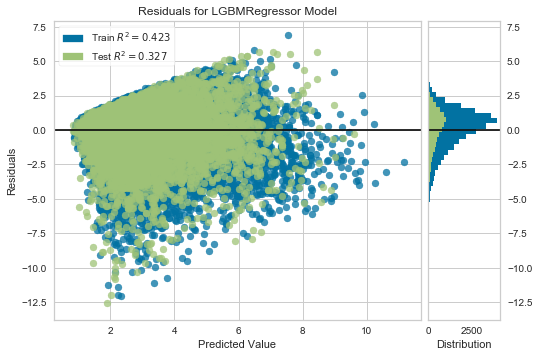

In [155]:
visualizer = ResidualsPlot(Final_LGBM)
visualizer.fit(X_train_2, y_train_2)
visualizer.score(X_test, (y_test))
A = visualizer.show()

In [156]:
y_test_hat = Final_LGBM.predict(X_test)
y_train_hat = Final_LGBM.predict(X_train_2)
test_MAE = mean_absolute_error(y_test, y_test_hat)
train_MAE = mean_absolute_error(y_train_2, y_train_hat)

print('The Training MAE was ' + str(train_MAE))
print('The Test MAE was ' + str(test_MAE))

The Training MAE was 1.2619642061923135
The Test MAE was 1.3460927370698543


The mean absolute error of our test set is ~7% worse than that of out training set, but that is not terrible. It suggests that our model is *slightly overfit* to our training data, but for that sake of this project, I will not go any further in trying to lower the MAE of our test set.

In other ML modeling examples, however, I would take this feedback as an indicator that we have room to improve and would re-iterate on the model (feature engineering, hyperparameter tuning, feature selection) in order to create a more generalizable model that would perform at least as well, if not better, on the test set than the training set. 

In [157]:
#Reload original data set to get all columns
LoadData = "../data/ExpSepPos.csv"
df = pd.read_csv(LoadData, index_col = False)

#Save output df to pkl file...
Final = proc_df.copy()
index = Final.index
Final = df.loc[index] 
Final['Pred_Sep'] = Final_LGBM.predict(X)
Final.to_pickle("../data/Final_1.pkl")
Final.head()

,GameId,PlayId,Season,Team,Receiver,Nearest_Defender,Nearest_Def_Position,Opp,Wk,Qtr,...,Air_Time,TTT,Separation,QB_Separation,QBP,QB_Scramble_Yds,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist,Pred_Sep
51974,2019122212,1208,2019,PHI,Greg Ward,Jourdan Lewis,CB,DAL,16,2,...,0.668,2.602,3.614540,1.294025,1,3.13,4.333330,1.636364,36.939999,1.500126
37741,2017112605,3533,2017,NYJ,Austin Seferian-Jenkins,James Bradberry,CB,CAR,12,4,...,1.214,4.488,1.223315,2.992073,0,24.26,6.463331,14.625000,1.300000,1.671222
2336,2017102908,799,2017,SEA,Tyler Lockett,Kareem Jackson,CB,HOU,8,1,...,2.069,2.213,0.384708,3.518892,0,2.70,4.593328,1.186364,52.919998,1.302965
37742,2017112605,3557,2017,NYJ,Austin Seferian-Jenkins,James Bradberry,CB,CAR,12,4,...,1.989,1.142,1.276127,1.969772,1,0.84,2.783331,1.697727,4.750000,1.328330
3538,2018112509,1001,2018,PIT,Xavier Grimble,Darian Stewart,FS,DEN,12,2,...,1.067,3.137,11.414131,4.660097,0,11.05,22.063330,4.581818,30.010002,3.797788


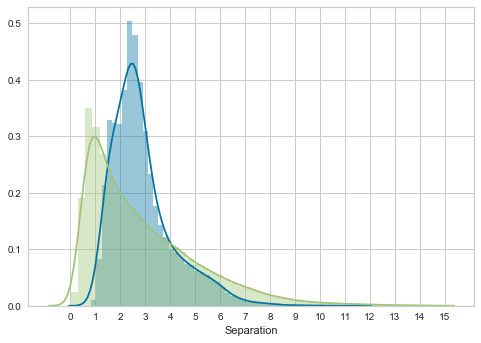

In [158]:
sns.distplot(Final['Pred_Sep'], kde_kws={'bw': .3})
sns.distplot(Final['Separation'], kde_kws={'bw': .3})
A =plt.xticks(range(-0, 16, 1))
# Add legend 

In [159]:
Final['Pred_Sep'].describe()

count    43559.000000
mean         2.885832
std          1.253565
min          0.838456
25%          2.032671
50%          2.596778
75%          3.371064
max         11.153038
Name: Pred_Sep, dtype: float64

In [152]:
Final['Separation'].describe()

count    43559.000000
mean         2.891849
std          2.206716
min          0.020000
25%          1.159871
50%          2.277982
75%          4.064400
max         14.472159
Name: Separation, dtype: float64

# Results!

In [161]:
import shap

In [162]:
%time 
explainer = shap.TreeExplainer(Final_LGBM)
shap_values = explainer.shap_values(X)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


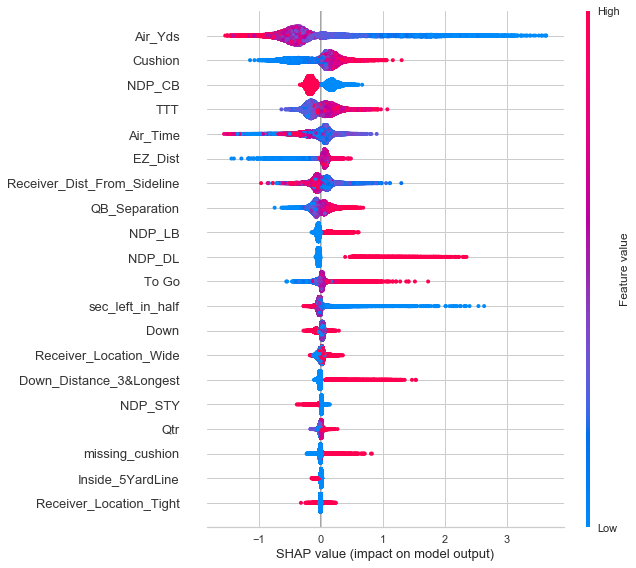

In [163]:
shap.summary_plot(shap_values, X)

The above [SHAP plot](https://github.com/slundberg/shap) gives an overview of how each feature contributed to the predicting separation on the whole. The Features (y-axis) are ordered by how often they were of significance to the prediction, with the most influential feature (Air Yards) at the top. The points themselves show how the value of each feauture was used to create the predictions. For example, when Air Yards values are low (blue) we can see that the model predicts a higher Separation (which, thankfully, makes sense). 

If we look at another feature, like NDP_DL (which is either a 1 or 0 value), it indicates that the model correctly understands that if the nearest defender was a DL on the play, it usually signified that the separation would higher, and therefore contributed to prediciting a higher separation value as well. 

In [164]:
orig_df = pd.read_pickle("../data/Orig.pkl")
Display = orig_df.copy().drop('Separation', axis = 1)
Display[float_cols] = Display[float_cols].round(2)

## How does the model work?

Below are two contrasting examples that show how the features are combined to create the predictions.

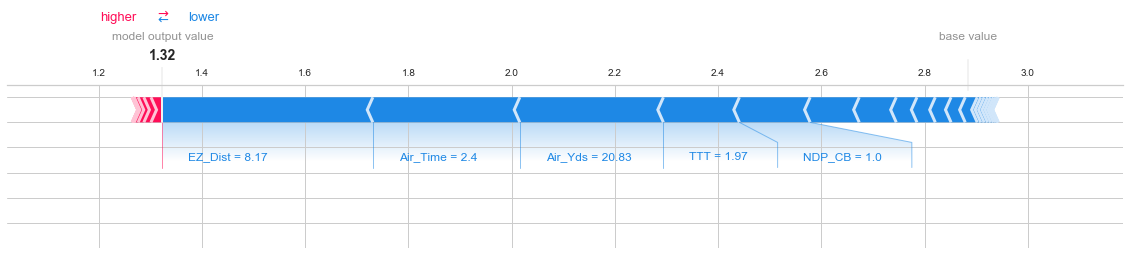

In [173]:
play = 7

shap.force_plot(explainer.expected_value, shap_values[play,:], Display.iloc[play,:], matplotlib = True)

In [174]:
#Actual Separation - Not Bad!
Final.iloc[7,:]['Separation']

0.58940649

On the above play, the model predicted that the player would have a **separation of 1.3 yards**. 

The pass traveled 21 yards downfield, was 8 yards from the back of the endzone, was in the air for 2.4 seconds, and the receiver was defended by a CB at the time the pass arrived. 

On the play, the player had an **actual separation of 0.6 yard**. Not bad!

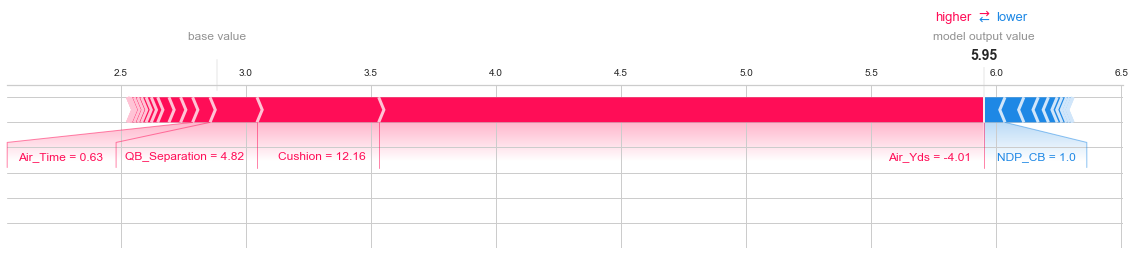

In [180]:
play = 12


shap.force_plot(explainer.expected_value, shap_values[play,:], Display.iloc[play,:], matplotlib = True)

In [181]:
#Actual Seproc_dfn - Also looks good!
Final.iloc[12,:]['Separation']

5.678256988999999

On this play, the model said that the player would have a **predicted separation of 6.0 yards**. 

This was due mostly to the fact that the pass targeted a receiver that was 4 yards *behind* the line of scrimmage. Other contributing factors were that the player had 12 yards of cushion and there was no one too close to the QB when he released the ball (4.82 QB separation).

On the play, the player had an **actual separation of 5.7 yards**. Excellent!